# Importing dependancies

In [1]:
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model definition

We can use the state variables (position of cart, angle of pole)

In [10]:
class DQN(nn.Module):

    def __init__(self, output_size):
        super(DQN, self).__init__()
        self.conv1 = nn.LazyConv2d(16, 3)
        self.conv2 = nn.LazyConv2d(32, 5)
        self.conv3 = nn.LazyConv2d(64, 5)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        self.flatten = nn.Flatten()
        
        self.fn1 = nn.LazyLinear(128)
        self.fn2 = nn.LazyLinear(64)
        self.fn3 = nn.LazyLinear(output_size)

        self.act = nn.PReLU()

    def forward(self, input):
        x = self.act(self.bn1(self.conv1(input)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.act(self.fn1(x))
        x = self.act(self.fn2(x))
        output = self.fn3(x)
        return output

# Memory
The agent should memorize what it learned before so it can learn from it

In [11]:
Experience = namedtuple('Experience', ('curr_state', 'action', 'next_state', 'reward', 'is_going'))

class Memory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def remember(self, *args):
        self.memory.append(Experience(*args))

    def recall(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        batch = Experience(*zip(*experiences))
        return batch

    def __len__(self):
        return len(self.memory)

# Creating the agent

In [12]:
class DDQNAgent:
    def __init__(self, env):
        env.reset()
        self.action_size = env.action_space.n # output size
        
        self.policy_model = DQN(self.action_size).to(device)
        self.target_model = DQN(self.action_size).to(device)
        self.target_model.load_state_dict(self.policy_model.state_dict())

        self.loss_fn = nn.SmoothL1Loss()
        self.optimizer = optim.Adam(self.policy_model.parameters(), lr=0.0005)

        self.exploration_rate = 1 # initial exploration rate, always leave at 1
        self.exploration_rate_decay = 0.999999 # rate at which the exploration decreases
        self.exploration_rate_min = 0.1 # minimun exploration rate
        
        self.gamma = 0.99 # falloff for Q score

        self.batch_size = 64
        self.num_epochs = 250
        self.update_rate = 10

        self.memory = Memory(10000) # how many of the previous samples are used
    
    def act(self, state):
        if random.random() < self.exploration_rate:
            action = random.randrange(self.action_size) # act randomly
        else:
            action = self.act_ideal(state) # act ideally
            
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        
        return action
    
    def act_ideal(self, state):
        return self.policy_model(state).max(1)[1].item()
    
    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.recall(self.batch_size)
        
        curr_states = torch.stack(batch.curr_state).squeeze(1)
        actions = torch.Tensor(np.array(batch.action)).to(device)
        next_states = torch.stack(batch.next_state).squeeze(1)
        rewards = torch.Tensor(np.array(batch.reward)).to(device)
        is_goings = torch.Tensor(np.array(batch.is_going)).to(device)
        
        # This is the fundamental logic behind calulating a deep Q value.
        curr_Q = self.policy_model(curr_states).mul(actions).sum(1)
        next_Q = self.target_model(next_states).max(1)[0]
        expected_Q = rewards + is_goings * self.gamma * next_Q

        loss = self.loss_fn(expected_Q, curr_Q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def train(self, env, print_epochs=False, render=False, checkpoint=False):

        scores = []

        for epoch in range(self.num_epochs):
            done = False
            curr_state = env.reset()
            curr_state = torch.Tensor(np.array(curr_state)).to(device)
            score = 0
            
            while not done:
                if render:
                    env.render()

                action = self.act(curr_state.unsqueeze(0))
                next_state, reward, done, _ = env.step(action)
                next_state = torch.Tensor(np.array(next_state)).to(device)
                action_encode = np.eye(self.action_size)[action]
                self.memory.remember(curr_state, action_encode, next_state, reward, 1 - done)

                curr_state = next_state
                      
                self.train_step()
                
                score += reward
            
            scores.append(score)

            if epoch % self.update_rate == 0:
                self.target_model.load_state_dict(self.policy_model.state_dict())

            if print_epochs:
                print("Epoch: " + str(epoch + 1) + ". Score is: " + str(score))
            
            if checkpoint and epoch % 50 == 0:
                torch.save(self, 'breakout.pt')
                np.save('breakout_scores.npy', scores)
        
        torch.save(self, 'breakout.pt')
        np.save('breakout_scores.npy', scores)

        return scores

    def train_until_solved(self, env, print_epochs=False, render=False, checkpoint=False):

        scores = []
        epoch = 0
        solved = False

        while not solved:
            done = False
            curr_state = env.reset()
            curr_state = torch.Tensor(np.array(curr_state)).to(device)
            score = 0
            
            while not done:
                if render:
                    env.render()

                action = self.act(curr_state.unsqueeze(0))
                next_state, reward, done, _ = env.step(action)
                next_state = torch.Tensor(np.array(next_state)).to(device)
                action_encode = np.eye(self.action_size)[action]
                self.memory.remember(curr_state, action_encode, next_state, reward, 1 - done)

                curr_state = next_state
                      
                self.train_step()
                
                score += reward
            
            scores.append(score)

            if epoch % self.update_rate == 0:
                self.target_model.load_state_dict(self.policy_model.state_dict())

            if print_epochs:
                print("Epoch: " + str(epoch + 1) + ". Score is: " + str(score))

            if len(scores) > 100 and np.mean(scores[-100:]) > 40:
                done = True
            
            if checkpoint and epoch % 50 == 0:
                torch.save(self, 'breakout.pt')
                np.save('breakout_scores.npy', scores)

            epoch += 1
        
        torch.save(self, 'breakout.pt')
        np.save('breakout_scores.npy', scores)
            
        return scores

    def test(self, env, num_trials=100, render=False):
        test_scores = []

        for i in range(num_trials):

            done = False
            curr_state = env.reset()
            curr_state = torch.Tensor(np.array(curr_state)).to(device)
            score = 0

            while not done:

                if render:
                    env.render()

                action = self.act_ideal(curr_state.unsqueeze(0))
                curr_state, reward, done, _ = env.step(action)
                curr_state = torch.Tensor(np.array(curr_state)).to(device)

                score += reward
            
            test_scores.append(score)
            
        return sum(test_scores) / num_trials

# Modifying the state space

There are a lot of uncessecary information in pong, so we can create wrappers that'll skip them

In [13]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Training the agent

In [14]:
env = gym.make("BreakoutNoFrameskip-v4")

env = SkipFrame(env, skip=2)
env = GrayScaleObservation(env)
env = ResizeObservation(env, 64)
env = FrameStack(env, num_stack=2)

agent = DDQNAgent(env)
scores = agent.train_until_solved(env, print_epochs=True, checkpoint=True)
plt.plot(scores)
plt.show()
print(agent.test(env))

C:\Users\Sean Jan's PC\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 1. Score is: 1.0
Epoch: 2. Score is: 0.0
Epoch: 3. Score is: 1.0
Epoch: 4. Score is: 0.0
Epoch: 5. Score is: 5.0
Epoch: 6. Score is: 1.0
Epoch: 7. Score is: 0.0
Epoch: 8. Score is: 0.0
Epoch: 9. Score is: 2.0
Epoch: 10. Score is: 0.0
Epoch: 11. Score is: 0.0
Epoch: 12. Score is: 0.0
Epoch: 13. Score is: 2.0
Epoch: 14. Score is: 2.0
Epoch: 15. Score is: 1.0
Epoch: 16. Score is: 0.0
Epoch: 17. Score is: 0.0
Epoch: 18. Score is: 0.0
Epoch: 19. Score is: 1.0
Epoch: 20. Score is: 1.0
Epoch: 21. Score is: 0.0
Epoch: 22. Score is: 1.0
Epoch: 23. Score is: 0.0
Epoch: 24. Score is: 0.0
Epoch: 25. Score is: 1.0
Epoch: 26. Score is: 2.0
Epoch: 27. Score is: 1.0
Epoch: 28. Score is: 1.0
Epoch: 29. Score is: 5.0
Epoch: 30. Score is: 0.0
Epoch: 31. Score is: 0.0
Epoch: 32. Score is: 1.0
Epoch: 33. Score is: 0.0
Epoch: 34. Score is: 0.0
Epoch: 35. Score is: 0.0
Epoch: 36. Score is: 0.0
Epoch: 37. Score is: 0.0
Epoch: 38. Score is: 2.0
Epoch: 39. Score is: 2.0
Epoch: 40. Score is: 0.0
Epoch: 41

KeyboardInterrupt: 

In [17]:
done = False
curr_state = env.reset()
curr_state = torch.Tensor(np.array(curr_state)).to(device)

while not done:
    env.render()

    action = agent.act_ideal(curr_state.unsqueeze(0))
    curr_state, _, done, _ = env.step(action)
    curr_state = torch.Tensor(np.array(curr_state)).to(device)

test_scores.append(score)

C:\Users\Sean Jan's PC\AppData\Local\Programs\Python\Python38\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


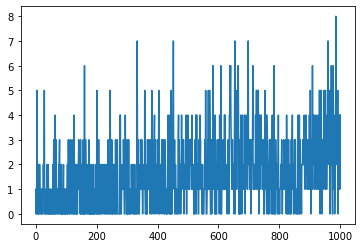

In [2]:
scores = np.load('breakout_scores.npy')
plt.plot(scores)